# News Article Topic Classification

---
With the decline of newspaper circulation, most news vendors turn to online distribution.  
With thousands of posts for a single publisher each day, manually inspecting each classification is a daunting task.  
* Difficult to find article of choice without proper classification.


In [0]:
# Libraries
from google.colab import drive

import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier


In [0]:
# Mount the local gdrive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Helper functions for data preprocessing

In [0]:
# read_data
# wraps for open, pandas' read_csv returns a dataframe of from the filename
def read_data(filename):
  with open(filename) as fp:
    return pd.read_csv(fp)

In [0]:
# show_dataDist
# prints the precentages of each category in the dataset and shows a pie chart of the category data
def show_dataDist(data_df, txt_col='text', lbl_col='label'):
  counts = np.bincount(le.fit_transform(data_df[lbl_col]))
  percents = np.clip(counts / counts.sum(), a_min=0, a_max=1)
  percents[0] = 1 - percents[1:].sum()
  labels = le.inverse_transform(range(len(percents)))
  plt.pie(percents, labels=labels)
  print(dict(zip(labels, percents)))

In [0]:
# reLabel
# renames the keys in a dictionary dataset of examples 
# returns the re-keyed dictionary
def reLabel(dict_list, txt_col='text', lbl_col='label'):
  for dict_element in dict_list:
    dict_element['label'] = dict_element.pop(lbl_col)
    dict_element['text'] = dict_element.pop(txt_col)
  return dict_list

In [0]:
# classical_method
# wraps a machine learning natural language processing pipeline as a generalizable function that takes an sklearn classifier
# and DataFrame dataset as input and shows the prediction metrics execution time for training and testing.
# returns the trained classifier so other predictions can be made.
def classical_method(data_df, classifier=MultinomialNB(), txt_col='text', lbl_col='label'):
  # Extract the data and labels to learn
  X = data_df[txt_col]
  y = data_df[lbl_col]

  # Number the string labels
  y = le.fit_transform(y)

  # Split the dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
  
  # Set up data pipeline
  pipe = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', classifier),
              ])
  
  # Time training execution
  start = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start
  print("Trained in %.3f seconds" % train_time)
  
  # Predict the labels on the test data
  y_pred = pipe.predict(X_test)
  
  # Output the prediction metrics
  print("Finished prediction in %.3f seconds" % (time.time() - start - train_time))
  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=le.classes_))

  # return the trained classifier so other predictions can be made.
  return pipe

### Load the datasets in DataFrame

In [0]:
# Directory paths in gdrive
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/'
bbc_filename = os.path.join(DIR_PATH, 'bbc-text.csv')
sports_filename = os.path.join(DIR_PATH, 'bbc-sport-fulltext.csv')
uciNews_filename = os.path.join(DIR_PATH, 'uci-news-aggregator.csv')

# Load the DataFrames
bbc_data = read_data(bbc_filename)
uciNews_data = read_data(uciNews_filename)
sports_data = read_data(sports_filename)

In [0]:
# Initialize sklearn's LabelEncoder to transform string categories to integers
le = LabelEncoder()

## Let's take a look at the data

In [0]:
# UCI News dataset
print('%d examples' % uciNews_data.shape[0])
uciNews_data.head()

422419 examples


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [0]:
# Truncate the UCI dataset to only those columns we need to predict topic categories
uciNews_dataset = uciNews_data[['TITLE', 'CATEGORY']]

{'b': 0.27453073843742826, 'e': 0.36094257123850965, 'm': 0.10804201515556829, 't': 0.2564846751684938}


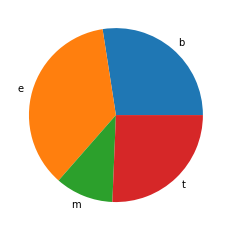

In [0]:
# Show the data distribution of the UCI News dataset
show_dataDist(uciNews_data, txt_col='TITLE', lbl_col='CATEGORY')

In [0]:
# BBCNews dataset
print('%d examples' % bbc_data.shape[0])
bbc_data.head()

2225 examples


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


{'business': 0.22921348314606738, 'entertainment': 0.17348314606741572, 'politics': 0.18741573033707865, 'sport': 0.22966292134831462, 'tech': 0.1802247191011236}


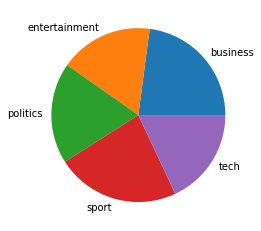

In [0]:
# Show the data distribution of the BBCNews dataset
show_dataDist(bbc_data, lbl_col='category')

In [0]:
# BBCSports dataset
print('%d examples' % sports_data.shape[0])
sports_data.head()

737 examples


,Unnamed: 0,label,text
0,0,athletics,Claxton hunting first major medal\n\nBritish h...
1,1,athletics,O'Sullivan could run in Worlds\n\nSonia O'Sull...
2,2,athletics,Greene sets sights on world title\n\nMaurice G...
3,3,athletics,IAAF launches fight against drugs\n\nThe IAAF ...
4,4,athletics,"Dibaba breaks 5,000m world record\n\nEthiopia'..."


{'athletics': 0.1370420624151969, 'cricket': 0.16824966078697423, 'football': 0.35956580732700133, 'rugby': 0.1994572591587517, 'tennis': 0.13568521031207598}


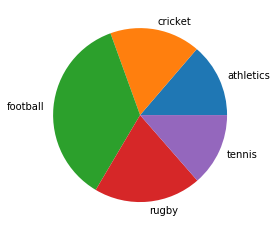

In [0]:
show_dataDist(sports_data)

# Predict

In [0]:
# Initialize the classical prediction classifiers with partial from functools
multinomial_bayes = partial(classical_method)
svm_linear_kernel = partial(classical_method, classifier=LinearSVC(loss='hinge', penalty='l2', random_state=12345, max_iter=5))
gradient_boost = partial(classical_method, classifier=LGBMClassifier(boosting_type='gbdt', objective='multiclass', random_state=12345))

### Multinomial Bayesian Classifier

In [0]:
print("Training Multinomial Bayesian Classifier on UCI News dataset")
mb_uci = multinomial_bayes(uciNews_data, txt_col='TITLE', lbl_col='CATEGORY')

Training Multinomial Bayesian Classifier on UCI News dataset
Trained in 3.467 seconds
Finished prediction in 1.396 seconds
accuracy 0.9227309313006012
              precision    recall  f1-score   support

           b       0.89      0.91      0.90     34868
           e       0.95      0.97      0.96     45630
           m       0.97      0.84      0.90     13658
           t       0.90      0.90      0.90     32570

    accuracy                           0.92    126726
   macro avg       0.93      0.91      0.92    126726
weighted avg       0.92      0.92      0.92    126726



In [0]:
print("Training Multinomial Bayesian Classifier on BBCNews dataset")
mb_bbcNews = multinomial_bayes(bbc_data, lbl_col='category')

Training Multinomial Bayesian Classifier on BBCNews dataset
Trained in 0.471 seconds
Finished prediction in 0.188 seconds
accuracy 0.9446107784431138
               precision    recall  f1-score   support

     business       0.96      0.95      0.96       164
entertainment       1.00      0.83      0.91       113
     politics       0.88      0.99      0.93       113
        sport       0.92      1.00      0.96       146
         tech       0.98      0.93      0.95       132

     accuracy                           0.94       668
    macro avg       0.95      0.94      0.94       668
 weighted avg       0.95      0.94      0.94       668



In [0]:
print("Training Multinomial Bayesian Classifier on BBCSports dataset")
mb_bbcSports = multinomial_bayes(sports_data)

Training Multinomial Bayesian Classifier on BBCSports dataset
Trained in 0.146 seconds
Finished prediction in 0.057 seconds
accuracy 0.6216216216216216
              precision    recall  f1-score   support

   athletics       1.00      0.16      0.27        38
     cricket       1.00      0.46      0.63        37
    football       0.51      1.00      0.67        87
       rugby       1.00      0.68      0.81        31
      tennis       1.00      0.24      0.39        29

    accuracy                           0.62       222
   macro avg       0.90      0.51      0.55       222
weighted avg       0.81      0.62      0.58       222



### SVM Linear Kernel Classifier

In [0]:
print("Training SVM Linear Kernel Classifier on UCI News dataset")
svm_uci = svm_linear_kernel(uciNews_data, txt_col='TITLE', lbl_col='CATEGORY')
pickle.dump(svm_uci, open('svm_uci.sav', 'wb'))

Training SVM Linear Kernel Classifier on UCI News dataset


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Trained in 4.865 seconds
Finished prediction in 1.390 seconds
accuracy 0.9484162681691208
              precision    recall  f1-score   support

           b       0.92      0.94      0.93     34868
           e       0.97      0.98      0.98     45630
           m       0.97      0.92      0.95     13658
           t       0.94      0.93      0.93     32570

    accuracy                           0.95    126726
   macro avg       0.95      0.94      0.95    126726
weighted avg       0.95      0.95      0.95    126726



In [0]:
print("Training SVM Linear Kernel Classifier on BBCNews dataset")
svm_bbcNews = svm_linear_kernel(bbc_data, lbl_col='category')
pickle.dump(svm_bbcNews, open('svm_bbcNews.sav', 'wb'))

Training SVM Linear Kernel Classifier on BBCNews dataset


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Trained in 0.502 seconds
Finished prediction in 0.188 seconds
accuracy 0.9775449101796407
               precision    recall  f1-score   support

     business       0.99      0.94      0.96       164
entertainment       0.99      0.98      0.99       113
     politics       0.94      0.99      0.97       113
        sport       0.98      1.00      0.99       146
         tech       0.98      0.98      0.98       132

     accuracy                           0.98       668
    macro avg       0.98      0.98      0.98       668
 weighted avg       0.98      0.98      0.98       668



In [0]:
print("Training SVM Linear Kernel Classifier on BBCSports dataset")
svm_bbcSports = svm_linear_kernel(sports_data)
pickle.dump(svm_bbcSports, open('svm_bbcSports.sav', 'wb'))

Training SVM Linear Kernel Classifier on BBCSports dataset
Trained in 0.163 seconds
Finished prediction in 0.056 seconds
accuracy 0.990990990990991
              precision    recall  f1-score   support

   athletics       1.00      1.00      1.00        38
     cricket       1.00      1.00      1.00        37
    football       0.98      1.00      0.99        87
       rugby       1.00      1.00      1.00        31
      tennis       1.00      0.93      0.96        29

    accuracy                           0.99       222
   macro avg       1.00      0.99      0.99       222
weighted avg       0.99      0.99      0.99       222



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Gradient Boosting Classifier

In [0]:
print("Training Gradient Boosting Classifier on UCI News dataset")
gb_uci = gradient_boost(uciNews_data, txt_col='TITLE', lbl_col='CATEGORY')

Training Gradient Boosting Classifier on UCI News dataset
Trained in 219.546 seconds
Finished prediction in 6.336 seconds
accuracy 0.857724539557786
              precision    recall  f1-score   support

           b       0.88      0.80      0.84     34868
           e       0.81      0.96      0.88     45630
           m       0.91      0.75      0.83     13658
           t       0.90      0.81      0.86     32570

    accuracy                           0.86    126726
   macro avg       0.88      0.83      0.85    126726
weighted avg       0.86      0.86      0.86    126726



In [0]:
print("Training Gradient Boosting Classifier on BBCNews dataset")
gb_bbcNews = gradient_boost(bbc_data, lbl_col='category')

Training Gradient Boosting Classifier on BBCNews dataset
Trained in 21.007 seconds
Finished prediction in 0.223 seconds
accuracy 0.9595808383233533
               precision    recall  f1-score   support

     business       0.94      0.94      0.94       164
entertainment       0.99      0.96      0.97       113
     politics       0.94      0.94      0.94       113
        sport       0.98      1.00      0.99       146
         tech       0.95      0.96      0.96       132

     accuracy                           0.96       668
    macro avg       0.96      0.96      0.96       668
 weighted avg       0.96      0.96      0.96       668



In [0]:
print("Training Gradient Boosting Classifier on BBCSports dataset")
gb_bbcSports = gradient_boost(sports_data)

Training Gradient Boosting Classifier on BBCSports dataset
Trained in 3.816 seconds
Finished prediction in 0.059 seconds
accuracy 0.963963963963964
              precision    recall  f1-score   support

   athletics       1.00      0.95      0.97        38
     cricket       1.00      1.00      1.00        37
    football       0.94      0.98      0.96        87
       rugby       0.97      0.94      0.95        31
      tennis       0.93      0.93      0.93        29

    accuracy                           0.96       222
   macro avg       0.97      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222



# Prediction Scratch Pad
### Let's make some topic predictions using the best of the classifiers for each dataset.
* SVM was the winner across the board

In [0]:
# UCI News Predictor
test_str = """Tory leader will address the United Conservative Party convention amid leadership concerns"""

# Load the saved model with pickle
svm_uci = pickle.load(open('svm_uci.sav', 'rb'))

# Predict on the test string
le.fit(uciNews_data.CATEGORY)
pred = le.inverse_transform(svm_uci.predict([test_str,]))[0]

# Show the prediction
print(test_str)
print('is a %s topic.' % pred)

Tory leader will address the United Conservative Party convention amid leadership concerns
is a e topic.


In [0]:
# BBCNews Predictor
test_str = """Tory leader will address the United Conservative Party convention amid leadership concerns"""

# Load the saved model with pickle
svm_bbcNews = pickle.load(open('svm_bbcNews.sav', 'rb'))

# Predict on the test string
le.fit(bbc_data.category)
pred = le.inverse_transform(svm_bbcNews.predict([test_str,]))[0]

# Show the prediction
print(test_str)
print('is a %s topic.' % pred)

Tory leader will address the United Conservative Party convention amid leadership concerns
is a politics topic.


In [0]:
# BBCSports Predictor
test_str = "Pakistan sends teenagers to compete against India after ITF moves fixture from Islamabad to Kazakhstan over security."

# Load the saved model with pickle
svm_bbcSports = pickle.load(open('svm_bbcSports.sav', 'rb'))

# Predict on the test string
le.fit(sports_data.label)
pred = le.inverse_transform(svm_bbcSports.predict([test_str,]))[0]

# Show the prediction
print(test_str)
print('is a %s topic.' % pred)

Pakistan sends teenagers to compete against India after ITF moves fixture from Islamabad to Kazakhstan over security.
is a cricket topic.
